<a href="https://colab.research.google.com/github/kangmg/ase-distortion-interaction/blob/main/notebook/ase_dias_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install conda

!rm -rf /content/sample_data
!rm -rf /content/condacolab_install.log

try:
  import condacolab
  condacolab.check()
except:
  %pip install condacolab
  import condacolab
  condacolab.install()

In [ ]:
#@title install dependencies
from IPython.display import clear_output
import locale

# fix colab gpu error
locale.getpreferredencoding = lambda: "UTF-8"


# torchani
!pip install -q torchani


# tblite
!conda install -q tblite
!conda install -q tblite-python


# ase_dias
!pip install -q git+https://github.com/kangmg/ase-distortion-interaction.git


# pyscf4gpu
!wget https://raw.githubusercontent.com/kangmg/PySCF4ASE/main/setup.sh -O setup.sh
!chmod +x setup.sh
!./setup.sh


# mopac
# lastest version mopac installation
!wget -q http://openmopac.net/mopac-22.1.1-linux.tar.gz -O ./mopac.tar.gz
!tar vxzf ./mopac.tar.gz
!rm ./mopac.tar.gz
import os
os.environ['PATH'] += ':/content/mopac-22.1.1-linux/bin' # append mopac run file path

clear_output()

In [37]:
#@title XequiNet requirements.txt
%%writefile requirements.txt
torch>=2.0
torch-geometric
torch-cluster
torch-scatter
pytorch-warmup
e3nn>=0.5
pydantic>=2.6
ase>=3.22
pyscf>=2.4
geometric>=1.0

Overwriting requirements.txt


In [20]:
#@title install XequiNet
!pip install -q git+https://github.com/cationic/XequiNet.git
!pip install -r requirements.txt
!conda install -q tblite
!conda install -q tblite-python

  Preparing metadata (setup.py) ... done


In [ ]:
#@title backup

#!wget https://github.com/X1X1010/XequiNet/raw/refs/heads/master/xequinet/utils/pre_computed/wb97m-v_def2-tzvppd_sp.pt -O ./wb97m-v_def2-tzvppd_sp.pt
#!xeqjit -c wb97m-v_def2-tzvppd_sp.pt
#
#import torch
#torch.load('wb97m-v_def2-tzvppd_sp.pt')

#from xequinet.interface import XeqCalculator
#
#calc = XeqCalculator(model=' jit model ? ')
#
#import torch
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = torch.jit.load("wb97m-v_def2-tzvppd_sp.jit", map_location=device)

<font size=6 color=skyblue>**ase_dias test**</font>

In [7]:
import ase_dias
import pyscf4ase

print("ase_dias version : ", ase_dias.__version__)
print("pyscf4ase version : ", pyscf4ase.__version__)

ase_dias version :  0.0.1
pyscf4ase version :  0.0.1


In [8]:
from ase_dias import available_data, load_data

available_data()

________________________________________________________
Data Name         |   Description
__________________|_____________________________________
sn2.xyz           |   sn2 reaction 
wittig.xyz        |   wittig reaction
DA.xyz            |   diels alder reaction
fluoroethane.xyz  |   unimolecular thermal decomposition
__________________|_____________________________________



In [9]:
# download file
load_data("sn2.xyz", save_file=True)
load_data("DA.xyz", save_file=True)

sn2.xyz file saved in ./sn2.xyz
DA.xyz file saved in ./DA.xyz


ase_dias CALCULATION TERMINATED NORMALLY


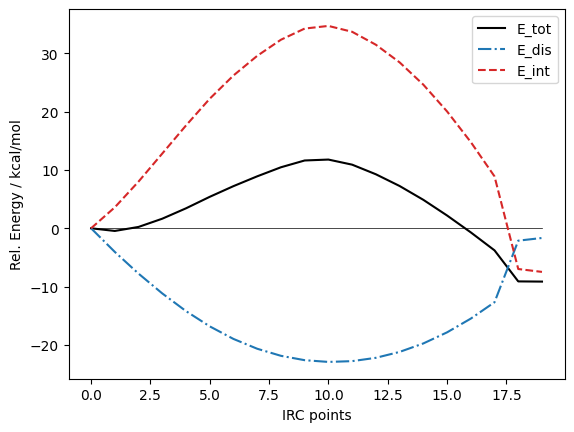

In [64]:
from ase_dias import dias_run, AIMNet2Calculator, load_aimnet2

# fragments_params
fp_n3 = {
  "Br-"   : (-1, [2]),
  "CH3+"  : (+1, [1,3,4,5]),
  "Cl-"   : (-1, [6])
}

model = load_aimnet2()
aimnet2_calc = lambda **kwargs : AIMNet2Calculator(model=model, **kwargs)

dias_run(
  calc=aimnet2_calc,
  trajFile="sn2.xyz",
  fragments_params=fp_n3,
  #use_spin=False
  )

ase_dias CALCULATION TERMINATED NORMALLY


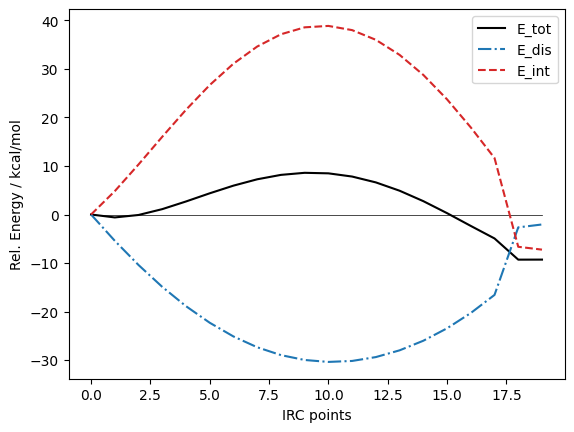

In [16]:
from ase_dias import dias_run
from pyscf4ase.dft import PySCFCalculator

# fragments_params
fp_n3 = {
  "Br-"   : (-1, [2]),
  "CH3+"  : (+1, [1,3,4,5]),
  "Cl-"   : (-1, [6])
}

def reference_dft_calc(**kwargs):
  """AIMNet2 reference DFT calculator
  """
  parameters = {
      **kwargs,
      "xc"  : 'wb97m-d3bj',
      "basis" : 'def2-tzvpp',
      "device" : 'gpu',
      "verbose" : 0
  }

  return PySCFCalculator(**parameters)

dias_run(
  calc=reference_dft_calc,
  trajFile="sn2.xyz",
  fragments_params=fp_n3,
  use_spin=False
  )

# 약 3시간 소요

ase_dias CALCULATION TERMINATED NORMALLY


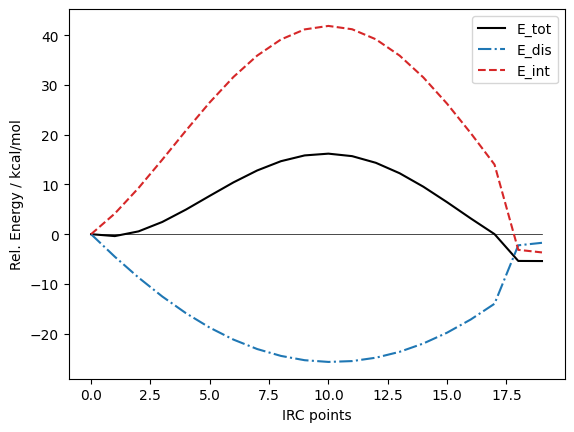

In [69]:
from ase_dias import dias_run
from ase.calculators.mopac import MOPAC

# fragments_params
fp_n3 = {
  "Br-"   : (-1, [2]),
  "CH3+"  : (+1, [1,3,4,5]),
  "Cl-"   : (-1, [6])
}

#   [methods]
#   'AM1', 'MNDO', 'MNDOD', 'PM3', 'PM6', 'PM6-D3', 'PM6-DH+',
#   'PM6-DH2', 'PM6-DH2X', 'PM6-D3H4', 'PM6-D3H4X', 'PMEP', 'PM7',
#   'PM7-TS', 'RM1'

mopac_calc = lambda **kwargs : MOPAC(method='PM7', **kwargs)

dias_run(
  calc=mopac_calc,
  trajFile="sn2.xyz",
  fragments_params=fp_n3,
  use_spin=False
  )

ase_dias CALCULATION TERMINATED NORMALLY


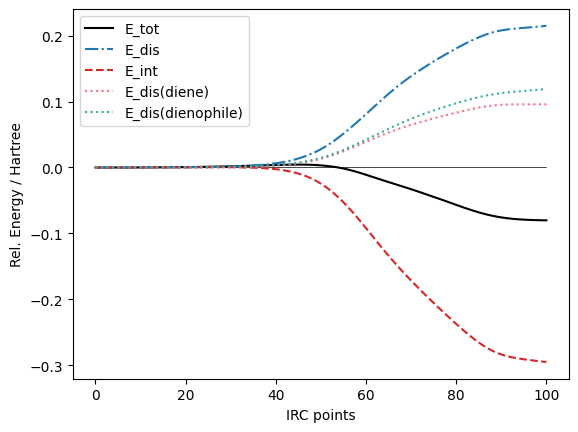

In [3]:
from tblite.ase import TBLite
from ase_dias import dias_run

# fragments_params
fp_DA = {
    "diene"        : (0, [7,8,11,12,14,20,21,22,23,24,25,26]),
    "dienophile"   : (0, [1,2,3,4,5,6,9,10,13,15,16,17,18,19])
    }

def xtb_calc(**kwargs):
  """xtb calculator wrapping ftn
  """
  spin = kwargs.get("spin")
  _kwargs = {
      **kwargs,
      'verbosity': 0,
      'accuracy':1,
      'max_iterations':350,
      #'initial_guess':'eeq'
      }
  kwargs['multiplicity'] = spin + 1 # `spin` is number of unpaired electrons (used in pyscf etc)
  kwargs.pop('spin', None)

  return TBLite(method="GFN2-xTB", **_kwargs)

# parameters
include_fragments=True                # show fragmets distortion energy
relative_idx=0                        # relative energy reference
unit="Hartree"                        # energy unit -- HArTrEe harTREE both possible

dias_run(
    calc=xtb_calc,
    trajFile="DA.xyz",
    fragments_params=fp_DA,
    include_fragments=include_fragments,
    relative_idx=relative_idx,
    unit=unit,
    use_spin=True
    )

ase_dias CALCULATION TERMINATED NORMALLY


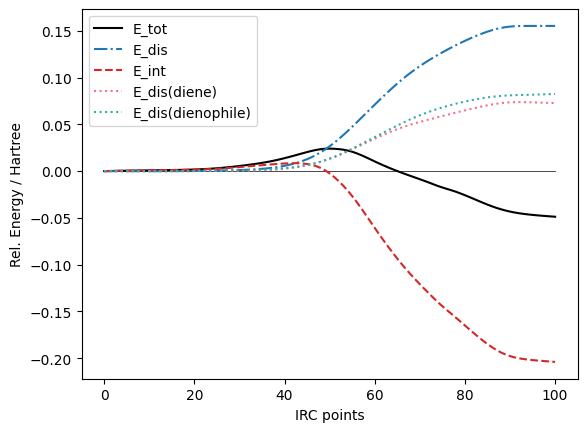

In [15]:
from ase_dias import dias_run
from torchani.models import ANI1ccx
import torch

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model caching can accelerate inference speed. A cached model can skip model loading.
_cached_model = {}

def torchani_calc(**kwargs):
  """torchani calculator wrapping ftn
  """
  # remove charge parameter
  _kwargs = {**kwargs}
  _kwargs.pop("charge", None)

  # load cached model
  if _cached_model.get("ani1ccx") is None:
    _cached_model["ani1ccx"] = ANI1ccx().to(device).ase()
  ani1ccx = _cached_model["ani1ccx"]

  return ani1ccx

# fragments_params
fp_DA = {
    "diene"        : (0, [7,8,11,12,14,20,21,22,23,24,25,26]),
    "dienophile"   : (0, [1,2,3,4,5,6,9,10,13,15,16,17,18,19])
    }

# parameters
include_fragments=True                # show fragmets distortion energy
relative_idx=0                        # relative energy reference
unit="Hartree"                        # energy unit -- HArTrEe harTREE both possible


dias_run(
    calc=torchani_calc,
    trajFile="DA.xyz",
    fragments_params=fp_DA,
    include_fragments=include_fragments,
    relative_idx=relative_idx,
    unit=unit,
    use_spin=False
    )

GPU-accelerated xtb

> https://dxtb.readthedocs.io/en/latest/01_quickstart/getting_started.html

> pip install -q dxtb[libcint]

In [ ]:
!pip install -q dxtb[libcint]

# ase calculator은 구현해야 함

In [ ]:
# import torch
# import dxtb

# dd = {"dtype": torch.double, "device": torch.device("cpu")}

# # LiH
# numbers = torch.tensor([3, 1], device=dd["device"])
# positions = torch.tensor([[0.0, 0.0, 0.0], [0.0, 0.0, 1.5]], **dd)

# # instantiate a calculator
# calc = dxtb.calculators.GFN1Calculator(numbers, **dd)

# # compute the energy
# pos = positions.clone().requires_grad_(True)
# energy = calc.get_energy(pos)

# # obtain gradient (dE/dR) via autograd
# (g,) = torch.autograd.grad(energy, pos)

# # Alternatively, forces can directly be requested from the calculator.
# # (Don't forget to manually reset the calculator when the inputs are identical.)
# calc.reset()
# pos = positions.clone().requires_grad_(True)
# forces = calc.get_forces(pos)

# assert torch.equal(forces, -g)

In [ ]:
#@title xtb error

from tblite.ase import TBLite
from ase_dias import dias_run

# calculation engine
def xtb_calc(**kwargs):
  """xtb calculator wrapping ftn
  """
  spin = kwargs.get("spin")
  _kwargs = {
      **kwargs,
      'verbosity': 0,
      'accuracy':1,
      'max_iterations':350,
      #'initial_guess':'eeq'
      }
  kwargs['multiplicity'] = spin + 1 # `spin` is number of unpaired electrons (used in pyscf etc)
  kwargs.pop('spin', None)

  return TBLite(method="GFN2-xTB", **_kwargs)

# fragments_params
fp_n2 = [
    (0, [1, 2, 3, 4, 5]), # Br-CH3
    (-1, [6]) # Cl-
]

# plot setting
unit               = "eV"        # "kJ/mol", "Hatree", "kcal/mol", "eV"
relative_idx       = 0           # min, 0 etc
include_fragments  = True        # plot distortion energies of each fragments
axis_type          = "distance"  # "angle", "dihedral"

# axis setting
gp = {"distance" : [2, 1]} # distance (C-Br)

dias_run(
    calc=xtb_calc,
    trajFile="sn2.xyz",
    fragments_params=fp_n2,
    geo_param=gp,
    axis_type=axis_type,
    include_fragments=include_fragments,
    relative_idx=relative_idx,
    unit=unit,
    use_spin=True
    )